In [179]:
"""
# coding: utf-8
@author: Yuhao Zhang
last updated: 05/30/2025
data from: Xinchao Chen
"""
%reset -f
%matplotlib inline
cutoff_distr = 80
data_path = '/data2/zhangyuhao/xinchao_data/Givenme/1423_15_control-Day1-VN-FM_g0'
save_path = "/home/zhangyuhao/Desktop/Result/ET/ISI/NP2/givenme/1423_15_control-Day1-VN-FM_g0"

import numpy as np
import matplotlib.pyplot as plt
from tick.hawkes import SimuHawkes, HawkesExpKern, HawkesKernelExp
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import STL

# Simulation
1. P.P.标准泊松过程
    1) 恒定速率
    2) 随机背景活动模拟
2. Periodic P.P.周期性泊松过程
    1) 无明确簇边界
    2）速率（尖峰密度）正弦调制
    4）节律编码的神经元活动，表现外部节律输入（如θ/γ节律）的影响
3. Hawkes P.自激励过程
    1) 簇大小不规则 （小簇2-3个尖峰，大簇10+尖峰）
    2) 簇间隔不规则 （随机的静息期）
    3) 簇内间隔递减 （开始密集，逐渐稀疏）
    4) 反映神经回路中的正反馈和短时可塑性，严重导致癫痫发作
4. Burst 爆发
    1) 簇大小固定
    2) 簇间隔规则
    3) 用于信息编码中的特征绑定和时间编码

In [194]:
total_time = 100  # unit s
np.random.seed(42)

# 生成泊松过程（恒定速率）
def Poisson(fr):
    n = np.random.poisson(fr * total_time)  # 计算时间段T内的事件总数（泊松分布）
    spike_times = np.sort(np.random.uniform(0, total_time, n))  # 在[0,T]内均匀生成n个事件时间点并排序
    isi = np.diff(spike_times)  # 计算事件间隔时间（Inter-Spike Interval）
    return spike_times, isi  # 返回事件时间序列和间隔序列

# 生成周期性泊松过程（周期性速率）
def PeriodicPoisson(fr,amplitude, period):
    events = []  # 存储事件时间的列表
    current_time = 0  # 当前时间指针
    while current_time < total_time:  # 在时间区间[0,T]内循环
        current_lamb = fr + amplitude * np.sin(2 * np.pi * current_time / period)  # 计算当前瞬时速率
        next_time = current_time + np.random.exponential(1 / current_lamb)  # 按指数分布生成下一个事件时间
        if next_time < total_time:  # 如果事件在时间范围内
            events.append(next_time)  # 记录事件时间
        current_time = next_time  # 移动到新生成的时间点

    spike_times = np.array(events)  # 转换为NumPy数组
    isi = np.diff(spike_times)  # 计算事件间隔
    return spike_times, isi  # 返回结果

def PeriodicPoisson2(mu=0.5, f0=100, phi=0, dt=0.001):
    """
    参数:
    mu -- 背景泊松速率 (Hz)
    f0 -- 周期频率 (Hz)
    phi -- 相位
    dt -- 时间步长 (秒)
    返回:
    spike_times -- spike时间数组
    isi -- 相邻spike间隔
    """
    time = np.arange(0, total_time, dt)
    periodic_spikes = (np.sin(2 * np.pi * f0 * time + phi) > 0.99).astype(int)
    poisson_spikes = np.random.rand(len(time)) < mu * dt
    spikes = np.logical_or(periodic_spikes, poisson_spikes)
    spike_times = time[spikes]
    isi = np.diff(spike_times)
    return spike_times, isi

def RenewalGamma(fr,isi_shape):
    # Generate ISIs from a Gamma distribution
    mean_isi = 1 / fr
    isis = np.random.gamma(shape=isi_shape, scale=mean_isi / isi_shape, size=int(total_time / mean_isi * 2))
    spike_times = np.cumsum(isis)
    spike_times = spike_times[spike_times < total_time]
    isi = np.diff(spike_times)
    return spike_times, isi

def Hawkes(fr,alpha, beta):
    # 创建指数衰减核：强度 = alpha * beta * exp(-beta*t)
    kernel = HawkesKernelExp(alpha * beta, beta)
    # 设置Hawkes过程参数
    hawkes = SimuHawkes(
        baseline=[fr],  # 基础强度
        kernels=[[kernel]],  # 指数衰减核（注意复数形式）
        end_time=total_time,  # 模拟时长
        verbose=False  # 不显示模拟信息
    )
    hawkes.simulate()  # 执行模拟
    spike_times = hawkes.timestamps[0]  # 获取第一维事件时间
    isi = np.diff(spike_times)  # 计算ISI
    return spike_times, isi

def Hawkes2(fr, alpha, beta):
    """
    参数:
    mu -- 基础强度
    alpha -- 自激励强度
    beta -- 衰减速率
    返回:
    spike_times -- 事件时间数组
    isi -- 相邻事件间隔数组
    """
    mu = fr * (1 - alpha/beta)
    t_events = []
    t = 0
    while t < total_time:
        lambda_t = mu
        for t_i in t_events:
            lambda_t += alpha * np.exp(-beta * (t - t_i))
        dt = -np.log(np.random.rand()) / lambda_t
        t += dt
        if t < total_time:
            t_events.append(t)
    spike_times = np.array(t_events)
    isi = np.diff(spike_times)
    return spike_times, isi

def Burst(fr,burst_jitter,spikes_per_burst,intra_burst_isi):
    """
    参数:
    T -- 总时间长度(秒)
    n_bursts -- 爆发次数(可选，默认根据burst_interval自动计算)
    burst_interval -- 爆发间隔(秒)
    burst_jitter -- 爆发起始时间抖动(标准差)
    spikes_per_burst -- 每次爆发放电次数
    intra_burst_isi -- 爆发内放电间隔(秒)
    返回:
    spike_times -- 尖峰时间数组
    isi -- 尖峰间隔数组
    """
    burst_interval = spikes_per_burst / fr
    n_bursts = int(total_time / burst_interval) + 1
    spike_times = []  # 所有尖峰时间
    for i in range(n_bursts):
        # 计算爆发起始时间（加入抖动）
        burst_start = i * burst_interval + np.random.normal(0, burst_jitter)
        # 确保爆发起始时间在[0, T]范围内
        if burst_start < 0:
            burst_start = 0
        elif burst_start > total_time:
            continue  # 跳过超出时间范围的爆发
        for j in range(spikes_per_burst):
            # 计算爆发内的尖峰时间
            spike_time = burst_start + j * intra_burst_isi
            
            # 只添加在时间范围内的尖峰
            if 0 <= spike_time <= total_time:
                spike_times.append(spike_time)
    
    # 转换为数组并排序
    spike_times = np.sort(np.array(spike_times))
    # 计算尖峰间隔
    if len(spike_times) > 1:
        isi = np.diff(spike_times)
    else:
        isi = np.array([])
    return spike_times, isi

def PeriodicBurstNNN(fr,T, burst_jitter):
    """
    参数:
    T -- 周期（ms），每T ms一个簇
    burst_rate -- 每个簇平均spike数（泊松分布均值）
    burst_jitter -- 簇内spike的抖动（标准差，ms）
    返回:
    spike_times -- 所有spike时间（升序）
    isi -- 相邻spike间隔
    """
    burst_rate = fr * T
    burst_centers = np.arange(0, total_time, T)
    spike_times = []

    for center in burst_centers:
        n_spikes = np.random.poisson(burst_rate)
        burst_spikes = np.random.normal(loc=center, scale=burst_jitter, size=n_spikes)
        burst_spikes = burst_spikes[(burst_spikes > 0) & (burst_spikes < total_time)]
        spike_times.extend(burst_spikes)

    spike_times = np.sort(np.array(spike_times))
    isi = np.diff(spike_times)
    return spike_times, isi

def PeriodicBurst(fr,T, burst_jitter):
    """
    参数:
    T -- 周期（ms），每T ms一个簇
    burst_rate -- 每个簇平均spike数（泊松分布均值）
    burst_jitter -- 簇内spike的抖动（标准差，ms）
    返回:
    spike_times -- 所有spike时间（升序）
    isi -- 相邻spike间隔
    """
    burst_rate = fr * T
    burst_centers = np.arange(0, total_time, T)
    spike_times = []

    for center in burst_centers:
        n_spikes = np.random.poisson(burst_rate)
        if n_spikes > 0:
            # 只保留每个 burst 中第一个 spike（最早那个）
            burst_spikes = np.random.normal(loc=center, scale=burst_jitter, size=n_spikes)
            burst_spikes = burst_spikes[(burst_spikes > 0) & (burst_spikes < total_time)]
            if len(burst_spikes) > 0:
                spike_times.append(np.min(burst_spikes))   # 只取最早那个

    spike_times = np.sort(np.array(spike_times))
    isi = np.diff(spike_times)
    return spike_times, isi

times_Poi, isi_Poi = Poisson(fr = 50) #lamb 发放率
times_Renew, isi_Renew = RenewalGamma(fr = 50,isi_shape=2.0)  # mean_isi (in seconds) isi_shape shape parameter for Gamma distribution
times_PerPoi, isi_PerPoi = PeriodicPoisson(fr = 50, amplitude=0.9, period=10)  # base_lamb基础速率 amplitude period 正弦波参数
times_Hawkes, isi_Hawkes = Hawkes(fr = 50, alpha=0.05, beta=3.5) # alpha 控制影响强度，beta 控制衰减速度
times_Hawkes2, isi_Hawkes2 = Hawkes2(fr = 50,alpha=0.05, beta=3.5)
times_Burst, isi_Burst = Burst(fr = 50,burst_jitter=0.05, spikes_per_burst=50, intra_burst_isi=0.4)
times_PerBurst, isi_PerBurst = PeriodicBurst(fr = 50,T = 0.01, burst_jitter = 0.001)

# Raster Plot

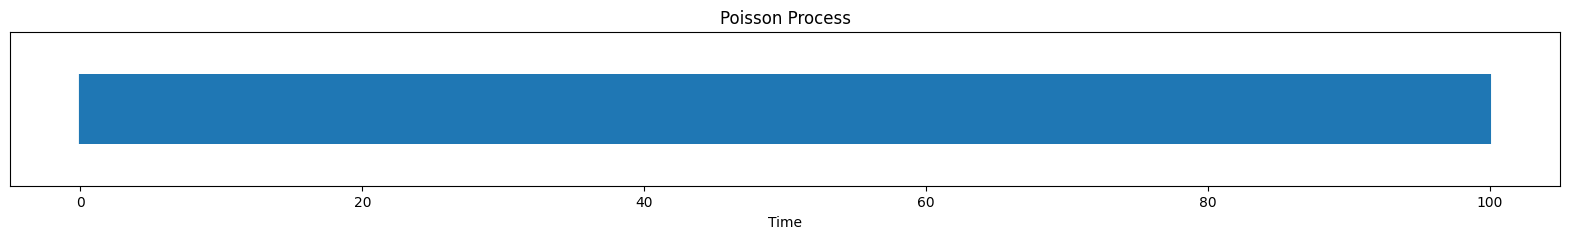

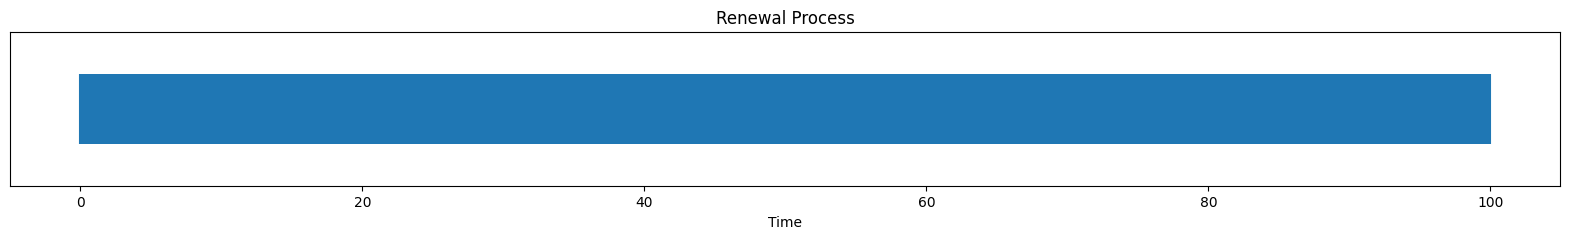

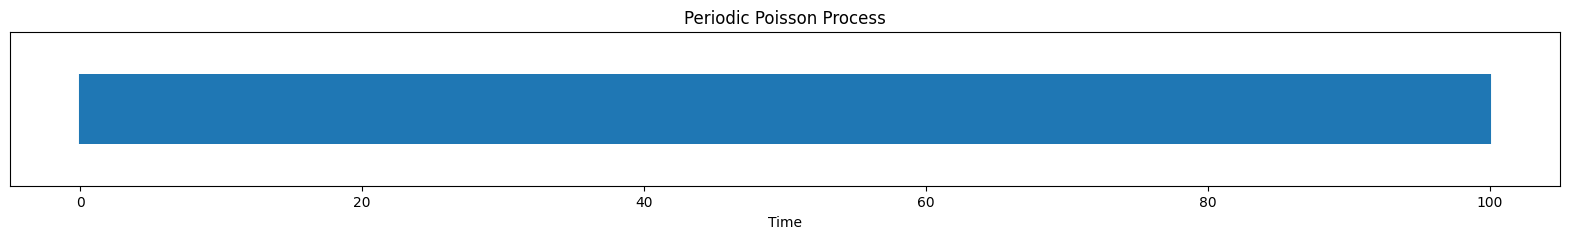

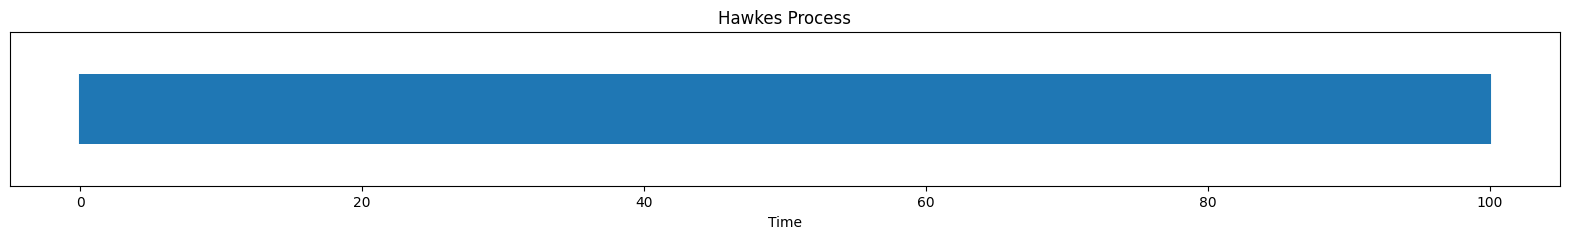

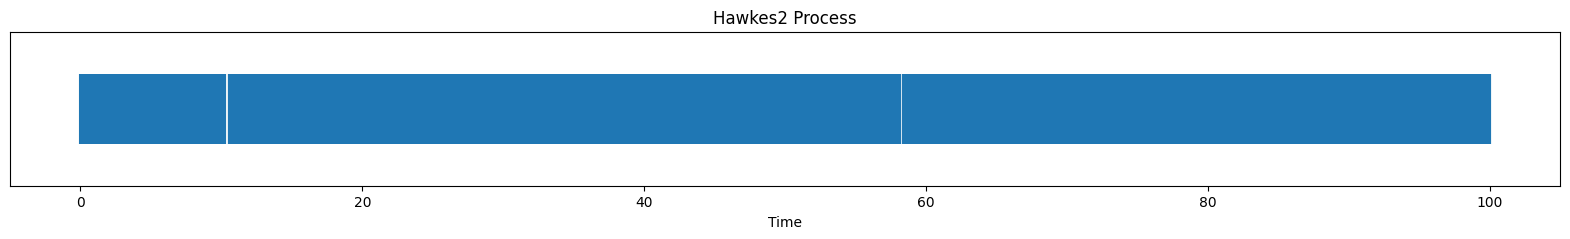

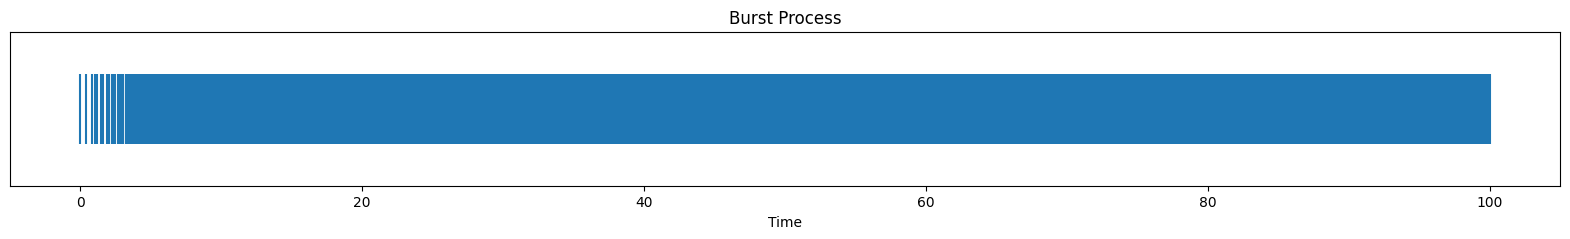

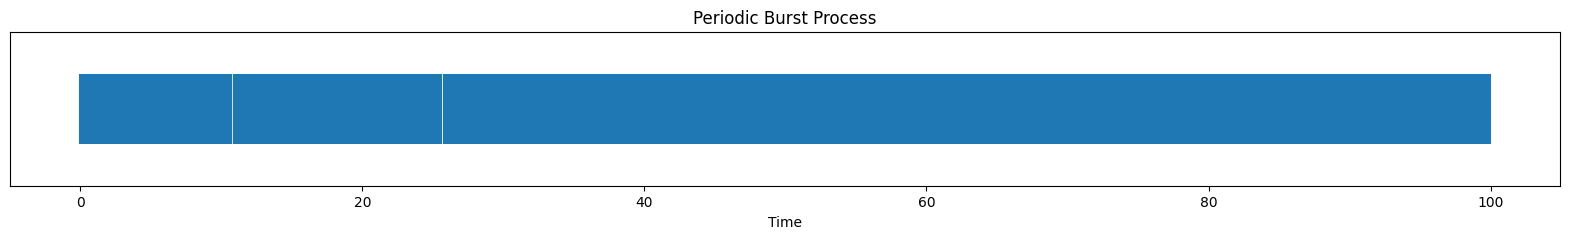

In [195]:
def plot_spiketrain(events, title):
    plt.figure(figsize=(20, 2))
    plt.eventplot(events, lineoffsets=0.5, linelengths=0.5)
    plt.title(title)
    plt.xlabel("Time")
    plt.yticks([])

plot_spiketrain(times_Poi, "Poisson Process")
plot_spiketrain(times_Renew, "Renewal Process")
plot_spiketrain(times_PerPoi, "Periodic Poisson Process")
plot_spiketrain(times_Hawkes, "Hawkes Process")
plot_spiketrain(times_Hawkes2, "Hawkes2 Process")
plot_spiketrain(times_Burst, "Burst Process")
plot_spiketrain(times_PerBurst, "Periodic Burst Process")

# Plot ISI

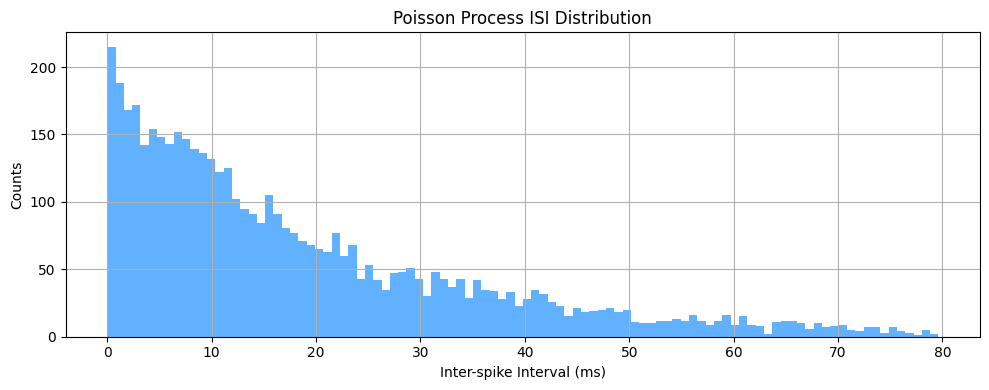

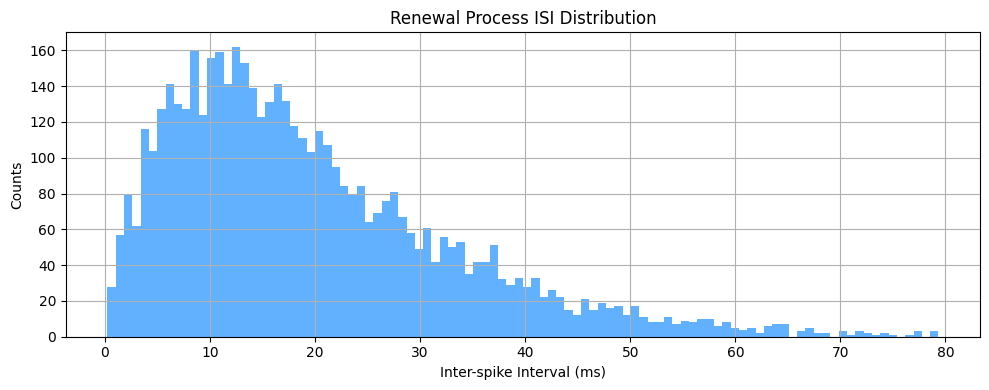

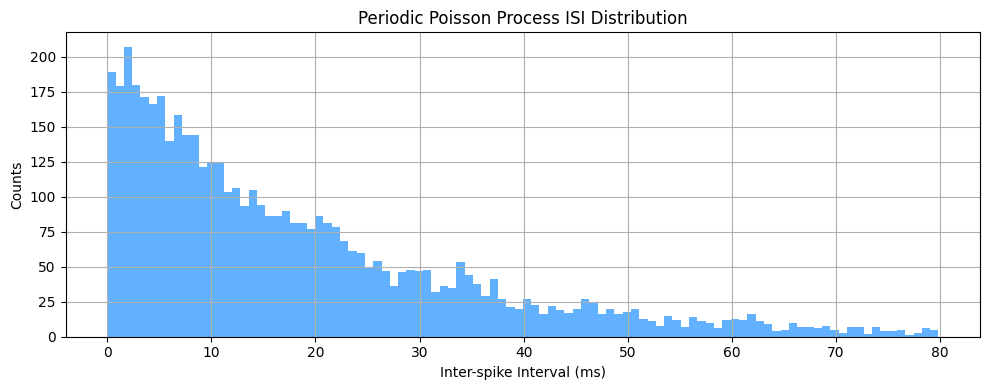

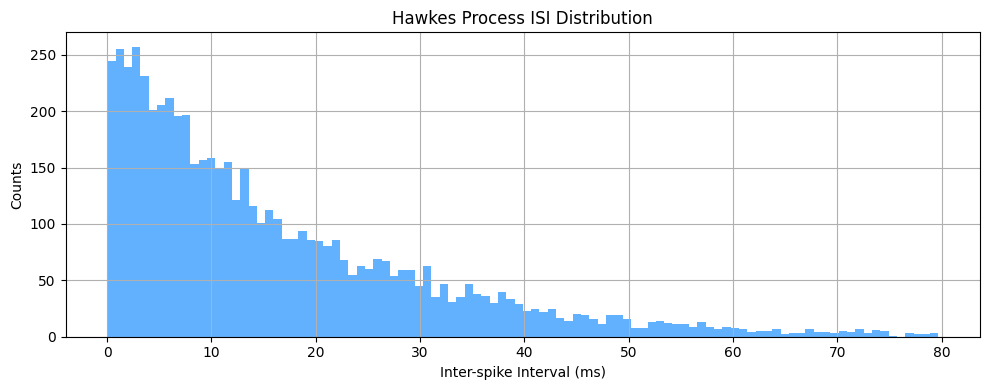

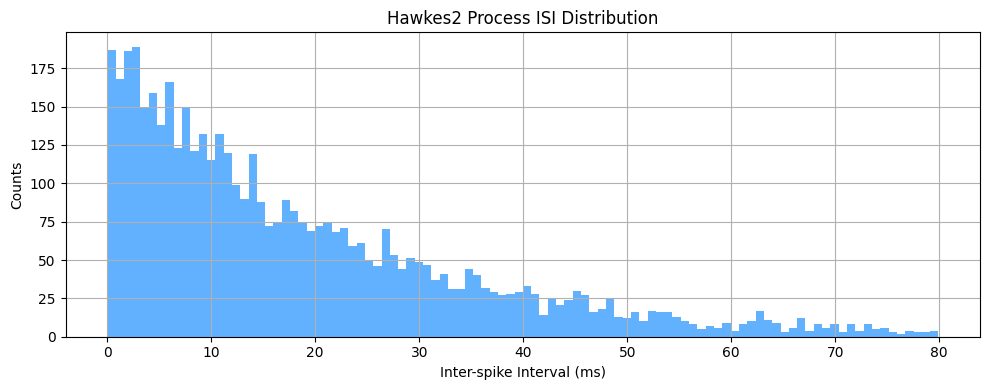

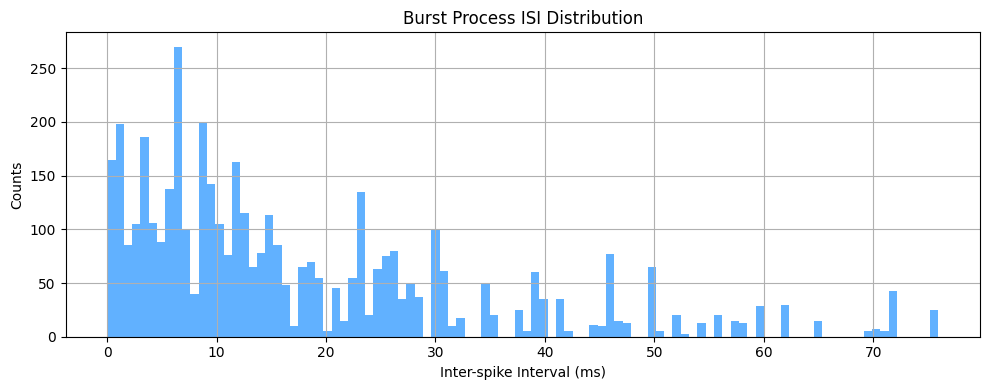

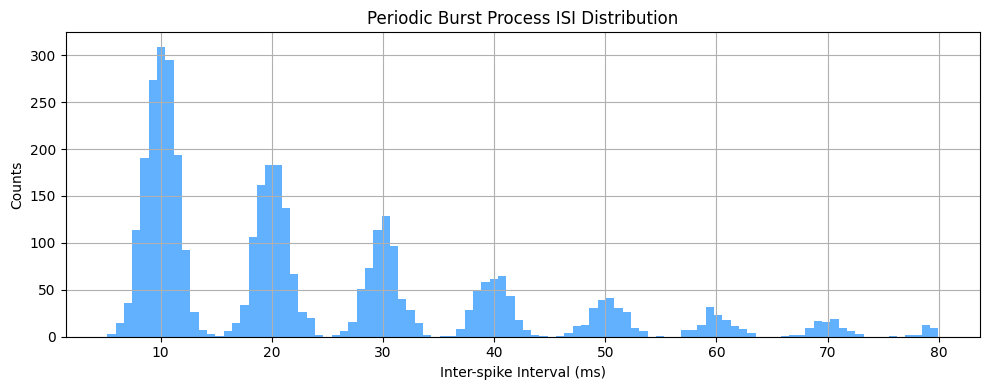

In [196]:
# 绘制 ISI 分布
def plot_isi(isi,name):
    isi = isi * 1000
    isi = isi[(isi > 0.001) & (isi <= cutoff_distr)]
    plt.figure(figsize=(10, 4))
    plt.hist(isi, bins=100, color='dodgerblue', alpha=0.7)
    plt.xlabel('Inter-spike Interval (ms)')
    plt.ylabel('Counts')
    plt.title(f'{name} ISI Distribution')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_isi(isi_Poi, "Poisson Process")
plot_isi(isi_Renew, "Renewal Process")
plot_isi(isi_PerPoi, "Periodic Poisson Process")
plot_isi(isi_Hawkes, "Hawkes Process")
plot_isi(isi_Hawkes2, "Hawkes2 Process")
plot_isi(isi_Burst, "Burst Process")
plot_isi(isi_PerBurst, "Periodic Burst Process")

# Compute ACF
泊松过程：ACF应接近0（无自相关）<br>
周期性过程：可能显示微弱周期性<br>
Hawkes过程：短时滞后上显著非零（聚集性）

In [ ]:
# 计算自相关函数（ACF）
def plot_acf(events, max_lag=10):  # 将max_lag从20减少到10
    if len(events) < 2:
        print("不足的事件数量来计算ACF")
        return
    
    intervals = np.diff(events)
    
    # 确保最大滞后不超过间隔序列长度
    max_lag = min(max_lag, len(intervals) - 1)
    
    if max_lag <= 0:
        print("不足的事件间隔来计算ACF")
        return
    
    acf_values = acf(intervals, nlags=max_lag, fft=True)
    plt.stem(range(max_lag+1), acf_values)
    plt.title("ACF of Inter-Event Times")
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.show()

# 使用更小的max_lag
plot_acf(events_periodic, max_lag=10)
plot_acf(events_poisson)     # ACF应接近零
plot_acf(events_periodic)    # ACF可能显示微弱周期
plot_acf(events_hawkes)      # ACF在短滞后上显著非零

# Use ACF to distingusih Hawkes Process

In [ ]:
from statsmodels.tsa.stattools import acf

# 加载数据
series1_path = r"C:\Users\zyh20\Desktop\Research\01_ET_data_analysis\Research\ISI_distribution\xinchao_np2_benchmark\20250310_benchmark_tremor_VN_spike_time_neuron_5.npy"
series2_path = r"C:\Users\zyh20\Desktop\Research\01_ET_data_analysis\Research\ISI_distribution\jiejue_data_benchmark\controlVN_spike_time_20221118_NP1_session3_neuron_30.npy"

t1 = np.load(series1_path)  # 替换为实际文件名
t2 = np.load(series2_path)


# 设定分箱宽度（根据数据调整）
bin_width = 0.1
max_time = max(np.max(t1), np.max(t2))
bins = np.arange(0, max_time + bin_width, bin_width)

# 生成计数序列
counts1, _ = np.histogram(t1, bins=bins)
counts2, _ = np.histogram(t2, bins=bins)

# 计算ACF，设置合适的滞后阶数
nlags = 40
acf1 = acf(counts1, nlags=nlags, fft=True)
acf2 = acf(counts2, nlags=nlags, fft=True)

# 绘制结果
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.stem(range(nlags+1), acf1, use_line_collection=True)
plt.title('ACF of Series 1')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.subplot(2, 1, 2)
plt.stem(range(nlags+1), acf2, use_line_collection=True)
plt.title('ACF of Series 2')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.tight_layout()
plt.show()


# Detection
1) 通过KS检验判断是否符合泊松过程
2) 通过STL分解检测周期性
3) 通过拟合Hawkes模型检测自激励特性

In [ ]:
# 1：泊松过程检验（Kolmogorov-Smirnov）
def test_poisson(events):
    intervals = np.diff(events)
    from scipy.stats import kstest, expon
    ks_stat, p_value = kstest(intervals, expon.cdf, args=(1/np.mean(intervals),))
    print(f"KS检验p值: {p_value:.3f} (p>0.05接受泊松假设)")

# 2：检测周期性（STL分解）
def detect_periodicity(events, period=10):
    counts, bins = np.histogram(events, bins=np.arange(0, T, 1))
    stl = STL(counts, period=period, seasonal=13)
    result = stl.fit()
    result.plot()
    plt.show()

# 3：拟合Hawkes模型，检查参数显著性
def fit_hawkes(events):
    # 使用 'decays' 而不是 'decay'
    model = HawkesExpKern(decays=1.0)  # 注意这里是 decays (复数)
    model.fit(events)
    print(f"Hawkes模型参数 - 基线: {model.baseline[0]:.3f}, 自激强度: {model.adjacency[0,0]:.3f}")
    return model.score()  # 返回对数似然

In [ ]:
print("=== Poisson Process ===")
test_poisson(events_poisson)
detect_periodicity(events_poisson)

print("\n=== Periodic Poisson Process ===")
test_poisson(events_periodic)  # 预期拒绝泊松假设
detect_periodicity(events_periodic)

print("\n=== Hawkes Process ===")
log_likelihood = fit_hawkes([events_hawkes])
test_poisson(events_hawkes)     # 预期拒绝泊松假设

# Power Spectrum Analysis

In [ ]:
def plot_spectrum(counts, bin_width, title):
    """
    计算并绘制功率谱密度
    :param counts: 分箱后的计数序列
    :param bin_width: 分箱宽度（秒）
    :param title: 图像标题
    """
    # 计算采样频率（Hz）
    fs = 1 / bin_width  # 例如 bin_width=0.1秒 → fs=10Hz
    
    # 使用Welch方法估计PSD
    f, Pxx = signal.welch(
        counts,
        fs=fs,
        window='hann',    # 汉宁窗减少频谱泄漏
        nperseg=256,      # 分段长度
        scaling='density' # 功率谱密度
    )
    
    # 可视化
    plt.figure(figsize=(10, 4))
    plt.semilogy(f, Pxx, color='blue')
    plt.title(f'Power Spectrum: {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.grid(True)
    
    # 标注最高峰
    peak_idx = np.argmax(Pxx[1:]) + 1  # 排除0频率
    plt.annotate(f'Peak: {f[peak_idx]:.2f} Hz\n(Period: {1/f[peak_idx]:.2f} sec)',
                 xy=(f[peak_idx], Pxx[peak_idx]),
                 xytext=(f[peak_idx]+0.2, Pxx[peak_idx]*0.8),
                 arrowprops=dict(arrowstyle="->"))
    plt.show()

# 分析Series 1（假设bin_width=0.1秒）
plot_spectrum(counts1, bin_width=0.1, title="Series 1")

# 分析Series 2
plot_spectrum(counts2, bin_width=0.1, title="Series 2")